In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime

from multiprocessing import Pool
from itertools import repeat

In [2]:
plt.style.use('seaborn-poster')

Модель ряда:

$$ 1.05\cos(\frac{2\pi}{24}n + \frac{3\pi}{4}) + 
                    0.82\cos(\frac{2\pi}{12} + \frac{\pi}{12}) + 
                    0.27\cos(\frac{2\pi}{8} - \frac{2\pi}{3}) + 
                    0.05\cos(\frac{2\pi}{6} - \frac{\pi}{3}) $$

In [575]:
real_impressions = pd.read_csv("/Users/klimmy/Klim/Statmod/2 семестр/SSA семинары/impressions.csv", 
                               sep = ",", 
                               decimal = ".",
                               names=['datetime','impressions'],
                               skiprows=1
                              )


In [636]:
real_imp_weekends = real_impressions.iloc[np.r_[119:168,288:336,456:504,600:672],:].reset_index()['impressions']

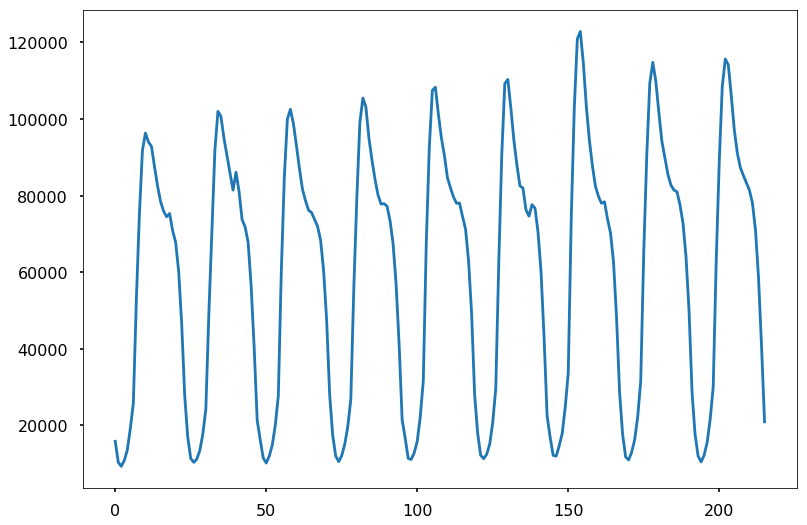

In [634]:
plt.plot(real_imp_weekends)
plt.show()

In [596]:
50000/1.5

33333.333333333336

In [618]:
temp = data_generator(ts_length=212, cp_prob=0, random_seed=10)[0]

In [626]:
pd.DataFrame(temp).to_csv('to_delete.csv', sep=';', decimal=',', index=False)

In [627]:
pd.DataFrame(real_imp_weekends).to_csv('to_delete_2.csv', sep=';', decimal=',', index=False)

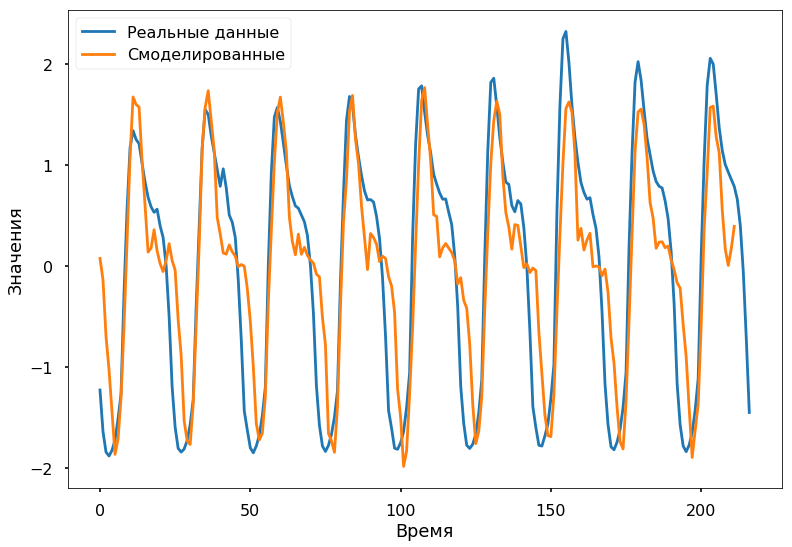

In [658]:
plt.plot((real_imp_weekends-np.mean(real_imp_weekends))/27000, label='Реальные данные')
plt.plot(data_generator(ts_length=212, cp_prob=0, random_seed=10)[0], label='Смоделированные')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.savefig('./fig/examples_real_vs_modeling.png')
plt.show()

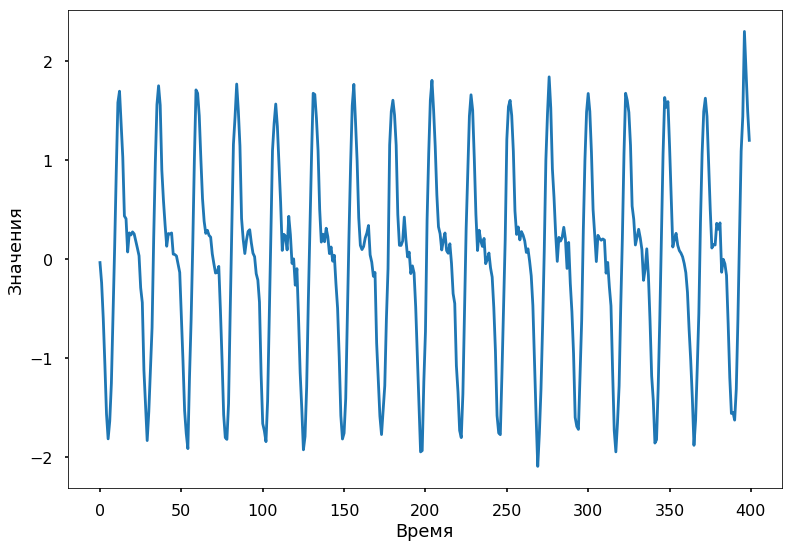

In [676]:
plt.plot(data_generator(ts_length=400, cp_prob=1, random_seed=19, change_point=396)[0])
plt.xlabel('Время')
plt.ylabel('Значения')
plt.savefig('./fig/data_modeling_example_2.png')
plt.show()

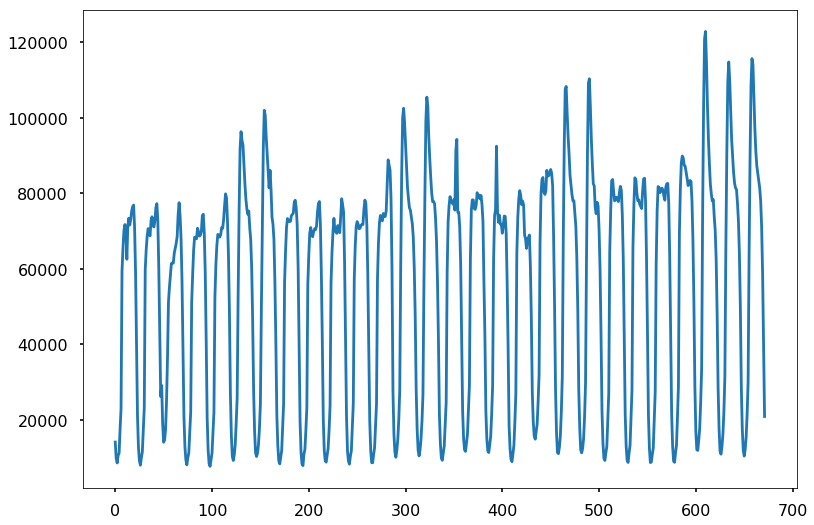

In [577]:
plt.plot(real_impressions['impressions'])

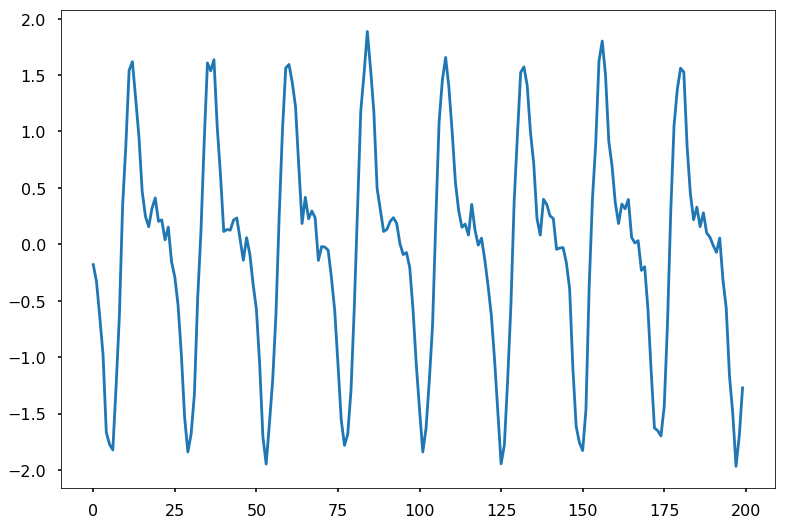

In [595]:
plt.plot(data_generator(ts_length=200)[0])
plt.show()

In [664]:
def data_generator(ts_length = 400, 
                   random_seed = None, 
                   cp_prob = 1, 
                   is_multiplicative = False, 
                   is_trend = False, 
                   change_type = 'mean',
                   change_point = 352):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.10,ts_length)
    signal = signal_trend+signal_period+noise

    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     print(norm)
#     print(time_series)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)


def get_model_trend_X(time_series):
    ts_length = len(time_series)
#     X = np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
    X = np.hstack((
        np.array([1 for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
              ))
    return X

def get_model_sin_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]) #,
#         np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def get_model_sin_insight_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

def approximation_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_trend_X(time_series[0:window])
    left_right_X = get_model_trend_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def approximation_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_X(time_series[0:window])
    left_right_X = get_model_sin_X(time_series[0:int(window/2)])
#     right_X = get_model_sin_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm
    
    return(result)


def approximation_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_insight_X(time_series[0:window])
    left_right_X = get_model_sin_insight_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def prediction_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_trend_X(time_series[0:int(window/2)])
    right_X = get_model_trend_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_X(time_series[0:int(window/2)])
    right_X = get_model_sin_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    norm = abs(np.mean(time_series[half_window:window])/np.mean(time_series[0:half_window]))+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
#     norm = np.mean([abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if (i >= half_window) and (i <= 2*window) ])

    result.extend([abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if i >= half_window])
#     temp = [abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if i >= half_window]
#     print(round(min(temp),1), round(np.mean(temp),1), round(max(temp),1), round(norm,1))
    return(result/norm)

def cp_detection(cost_values, threshold, cp_zone):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
                       if (cost_value >= threshold) and (ind >= cp_zone)]
#     list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
#                        if cost_value >= threshold]
    if len(list_of_indexes) == 0:
        return(None)
    else:
        return(list_of_indexes[0])   
#     return(list_of_indexes)

def any_to_list(inp):
    if isinstance(inp, list):
        return(inp)
    else:
        return([inp])

def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
#     df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
#     delay = list(df_temp['predicted'] - df_temp['actual'])
#     df.loc[(pd.isna(df['actual']) == False) & 
#            (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
#     return(conf_m, delay) 
    return(conf_m) 

def cp_detection_modeling_old(approach = 'approximation_mean', 
                          iterations = 1000, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    for i in range(iterations):
        generated = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        for threshold in threshold_list:
            act[counter] = generated[1]
            pred[counter] = cp_detection(cp_1, threshold, change_point)
            tr[counter] = threshold
            counter += 1
        
    return([act, pred, tr])

def cp_detection_modeling(approach = 'approximation_mean', 
                          iterations = 100, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    generated_list, act_list = np.empty((iterations,400)), np.empty(iterations) 
    for i in range(iterations):
        generated_list[i,:], act_list[i] = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)[0:2]
    
    with Pool() as p:
        if approach == 'approximation_mean':
            cp_1 = p.starmap(approximation_mean,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_mean':
            cp_1 = p.starmap(prediction_mean,zip(generated_list, repeat(_window)))
        elif approach == 'naive':
            cp_1 = p.starmap(naive,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_trend':
            cp_1 = p.starmap(approximation_trend,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_sin_trend':
            cp_1 = p.starmap(approximation_sin_trend,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = p.starmap(approximation_sin_insight_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_trend':
            cp_1 = p.starmap(prediction_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_sin_trend':
            cp_1 = p.starmap(prediction_sin_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = p.starmap(prediction_sin_insight_trend,zip(generated_list, repeat(_window)))
        else:
            raise ValueError("Unrecognized approach")
    
    for i in range(iterations):
        for threshold in threshold_list:
            act[counter] = act_list[i]            
            pred[counter] = cp_detection(cp_1[i], threshold, change_point)
#             if pred[counter] < change_point:
#                 print(pred[counter])
#             # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! This is for debugging only! Don't forget to remove it!
#             if (threshold < 1.67) & (threshold > 0.648):
#                 if pd.isnull(pred[counter]):
#                     pred[counter] = change_point
#                 else:
#                     pred[counter] = np.nan
                
            tr[counter] = threshold
            counter += 1
            
        
    return([act, pred, tr])



def get_threshold_list(iterations = 1000, 
                       approach = 'approximation_mean', 
                       window = 48, 
                       cp_prob = 0.8, 
                       is_multiplicative = False, 
                       is_trend = False, 
                       change_type = 'mean',
                       change_point=352):
    detection_values = []
    for i in range(iterations):  
        generated = data_generator(cp_prob = cp_prob, 
                                   is_multiplicative = is_multiplicative, 
                                   is_trend = is_trend, 
                                   change_type = change_type,
                                   change_point = change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
    threshold_max = np.percentile(detection_values, 95)
#     threshold_max = max(detection_values)*1.2
#     threshold_max = float(round(threshold_max,6))
    threshold_max = float(threshold_max)
    threshold_list = list(np.arange(0, threshold_max, threshold_max/1000))
    return(threshold_list)


def get_metrics(confusion):
    if sum(confusion[1,:]) == 0:
        recall = 1
    else:
        recall = confusion[1,1]/sum(confusion[1,:])

    if sum(confusion[0,:]) == 0:
        specificity = 1
    else:
        specificity = confusion[0,0]/sum(confusion[0,:])
    
    return(recall,specificity)

In [ ]:

cp_result = confusion_matrix(
                (np.isnan(actual[thresholds == tr]) == False)*1,
                (np.isnan(predicted[thresholds == tr]) == False)*1
            )


In [427]:
pred_

In [439]:
cp_quality([act_], [pred_])

array([[0, 0],
       [1, 0]])

394 396
[[0 0]
 [0 1]]


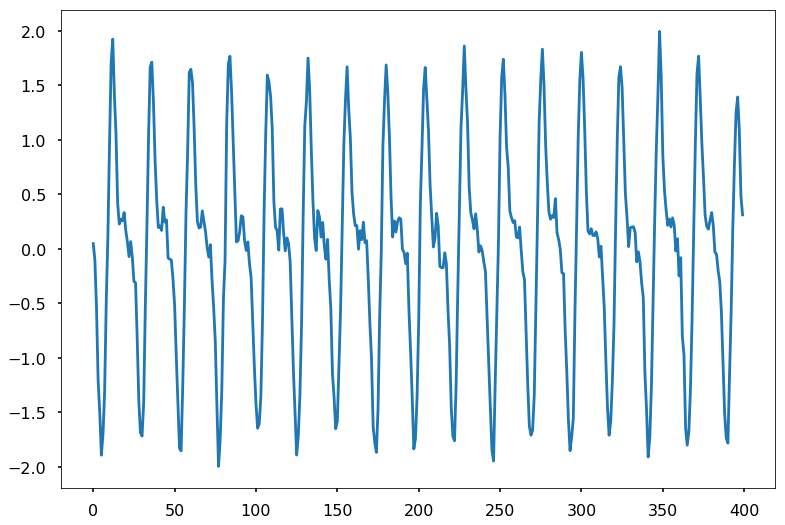

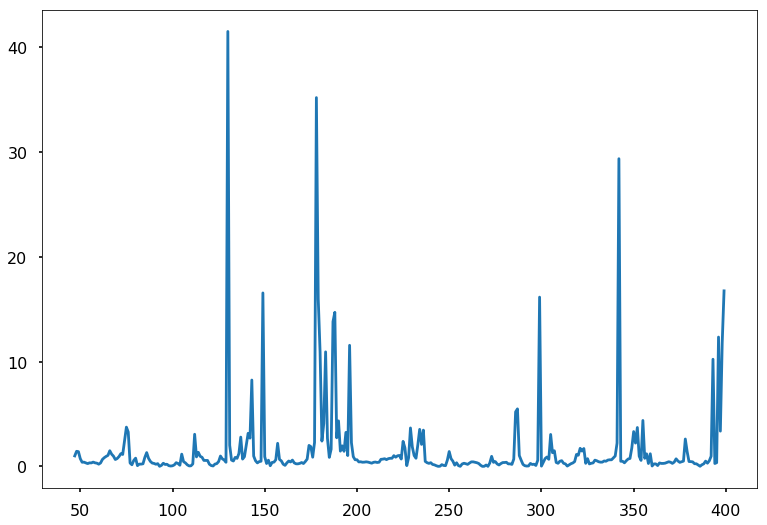

In [498]:
generated_, act_ = data_generator(cp_prob = 1, 
                               is_multiplicative = False, 
                               is_trend = False, 
                               change_type = 'mean',
                               change_point=394)[0:2]

cp_1_ = naive(generated_, 48)

pred_ = cp_detection(cp_1_, 1.5, 394)
ma = cp_quality([act_], [pred_])

print(act_, pred_)
print(ma)

plt.plot(generated_)
plt.show()
plt.plot(cp_1_)
plt.show()

In [502]:
window_ = 48
half_window_ = int(window_/2)
result_ = [np.nan]*(window_-1)

norm_ = np.mean(generated_[half_window_:window_])/np.mean(generated_[0:half_window_])+1


In [505]:
norm_

2.2478953931167047

In [506]:
left_right_ts_mean_ = np.convolve(generated_, np.ones((half_window_,))/half_window_, mode='valid')


In [496]:
pd.DataFrame(generated_).to_csv('temp_11.csv', sep=';', decimal=',', index=False)

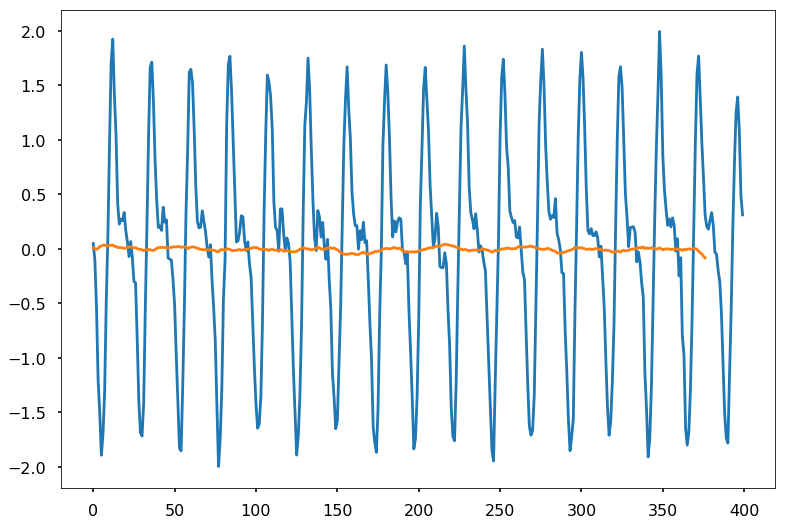

In [507]:
plt.plot(generated_)
plt.plot(left_right_ts_mean_)
plt.show()


In [508]:

result_.extend([abs(x/left_right_ts_mean_[i-half_window_]+1) for i, x in enumerate(left_right_ts_mean_) if i >= half_window_])


In [ ]:
[abs(x/left_right_ts_mean_[i-half_window_]-1) 
 for i, x in enumerate(left_right_ts_mean_) 
 if i >= half_window_]

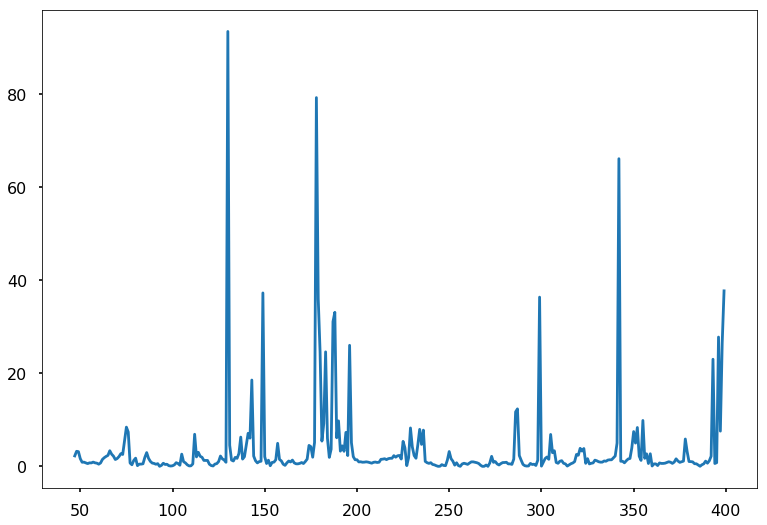

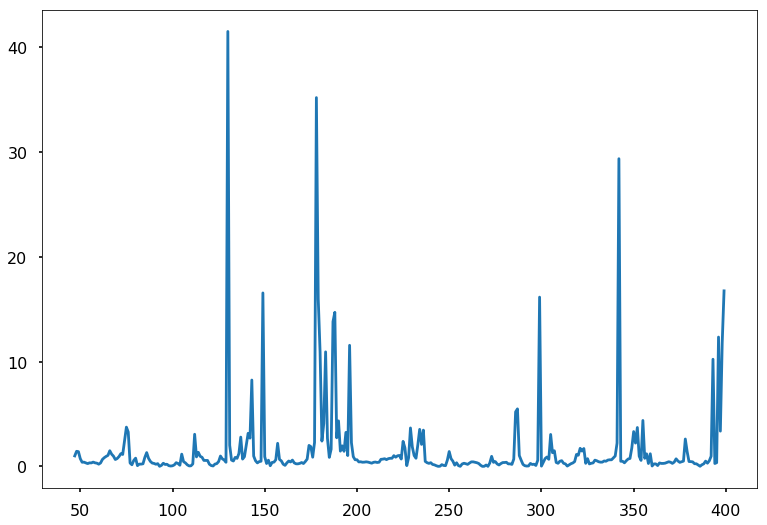

In [509]:
plt.plot(result_)
plt.show()
plt.plot(result_/norm_)
plt.show()

In [309]:
# a, b = [], []
# for i in range(100):

#     generated_, act_ = data_generator(cp_prob = 1, 
#                                    is_multiplicative = False, 
#                                    is_trend = False, 
#                                    change_type = 'mean',
#                                    change_point=394)[0:2]

#     cp_1_ = approximation_mean(generated_, 4)

#     pred_ = cp_detection(cp_1_, 1.5, 394)
#     ma = cp_quality([act_], [pred_])[0]
    
#     if ma[1,0] == 1:
#         a.append(1)
#     elif ma[1,1] == 1:
#         b.append(1)
# #     print(act_, pred_)
# #     print(cp_quality([act_], [pred_]))

# #     plt.plot(generated_)
# #     plt.plot(cp_1_)
# #     plt.show()

# print(sum(a), sum(b), sum(a)+sum(b), sum(a)/(sum(a)+sum(b)))

In [310]:
# a, b = [], []
# for i in range(100):

#     generated_, act_ = data_generator(cp_prob = 0, 
#                                    is_multiplicative = False, 
#                                    is_trend = False, 
#                                    change_type = 'mean',
#                                    change_point=394)[0:2]

#     cp_1_ = approximation_mean(generated_, 4)

#     pred_ = cp_detection(cp_1_, 1.5, 394)
#     ma = cp_quality([act_], [pred_])[0]
    
#     if ma[0,0] == 1:
#         a.append(1)
#     elif ma[0,1] == 1:
#         b.append(1)
# #     print(act_, pred_)
# #     print(cp_quality([act_], [pred_]))

# #     plt.plot(generated_)
# #     plt.plot(cp_1_)
# #     plt.show()

# print(sum(a), sum(b), sum(a)+sum(b), sum(a)/(sum(a)+sum(b)))

In [311]:
# plt.plot(cp_1_)

In [336]:

def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
#     df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
#     delay = list(df_temp['predicted'] - df_temp['actual'])
#     df.loc[(pd.isna(df['actual']) == False) & 
#            (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
#     conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
#     return(conf_m, delay) 
#     return(conf_m) 

ROC AUC: 0.45556478405315615


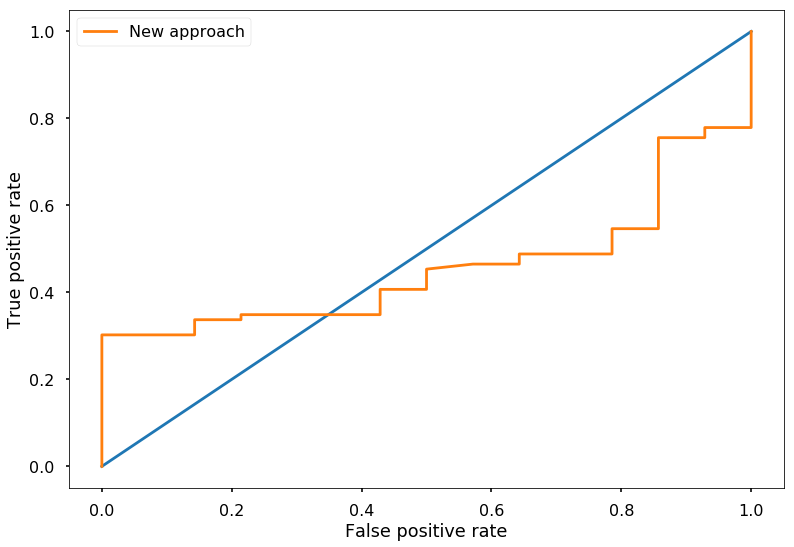

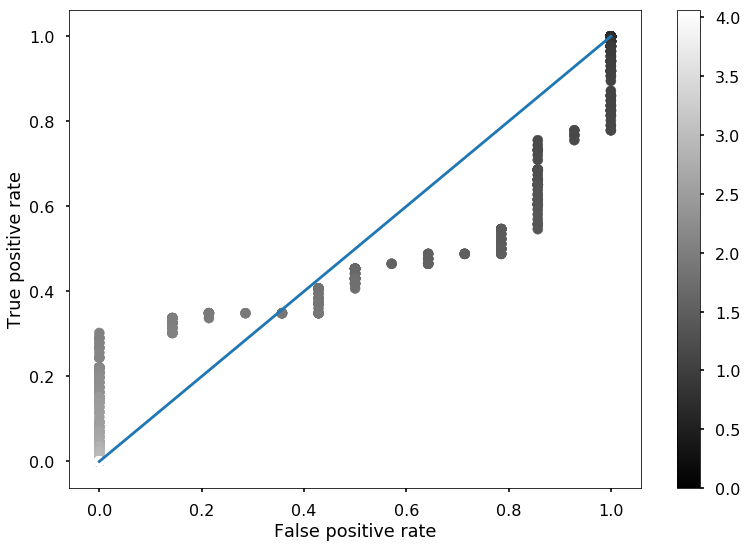

CPU times: user 4.34 s, sys: 144 ms, total: 4.48 s
Wall time: 4.26 s


In [340]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 394

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

# df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = confusion_matrix(
                    (np.isnan(actual[thresholds == tr]) == False)*1,
                    (np.isnan(predicted[thresholds == tr]) == False)*1
                )
#     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                           )
    if sum(cp_result[:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[1,1]/sum(cp_result[:,1]))

    if sum(cp_result[1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[1,1]/sum(cp_result[1,:]))

    if sum(cp_result[0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0,0]/sum(cp_result[0,:]))    

#     if cp_result[1]:
#         average_delay.append(np.mean(cp_result[1]))
#         precision_filter.append(True)
#     else:
#         precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [312]:
# df_cp['threshold'].unique()[116]

In [313]:
# number = df_cp['threshold'].unique()[387]
# print(number)

# ma = cp_quality(df_cp.loc[df_cp['threshold'] == number, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == number, 'predicted']
#                           )[0]

# print(ma)
# print('Recall: {} \nFPR: {}'.format(np.sum(ma[1,1])/np.sum(ma[1,:]),
#                                     np.sum(ma[0,1])/np.sum(ma[0,:])
#                                    ))

# # plt.scatter(np.sum(ma[1,:])/np.sum(ma), np.sum(ma[0,:])/np.sum(ma))

In [314]:
# number = df_cp['threshold'].unique()[300]
# print(number)

# ma = cp_quality(df_cp.loc[df_cp['threshold'] == number, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == number, 'predicted']
#                           )[0]

# print(ma)
# print('Recall: {} \nFPR: {}'.format(np.sum(ma[1,1])/np.sum(ma[1,:]),
#                                     np.sum(ma[0,1])/np.sum(ma[0,:])
#                                    ))

# # plt.scatter(np.sum(ma[1,:])/np.sum(ma), np.sum(ma[0,:])/np.sum(ma))

In [315]:
# # df_cp.loc[df_cp['threshold'] == number, 'actual']
# df_cp.loc[df_cp['threshold'] == number, 'predicted']

In [316]:
# np.sum(ma[1,:])/np.sum(ma)

ROC AUC: 0.8300844704353476


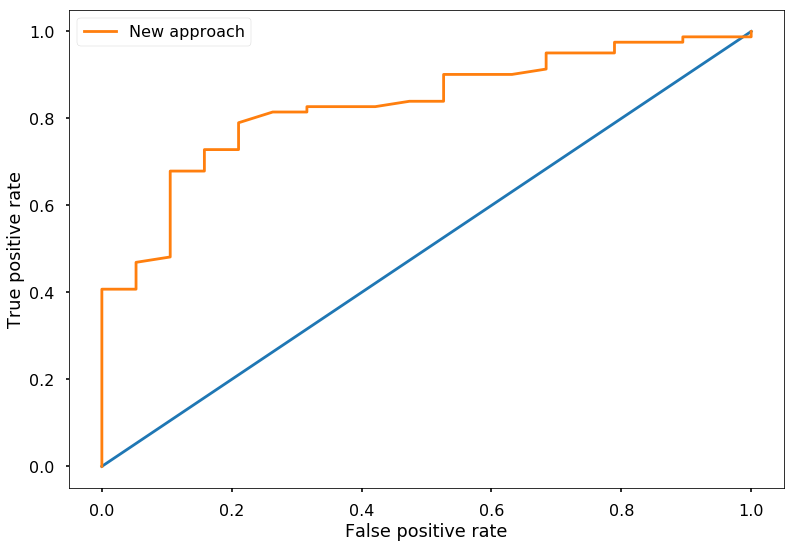

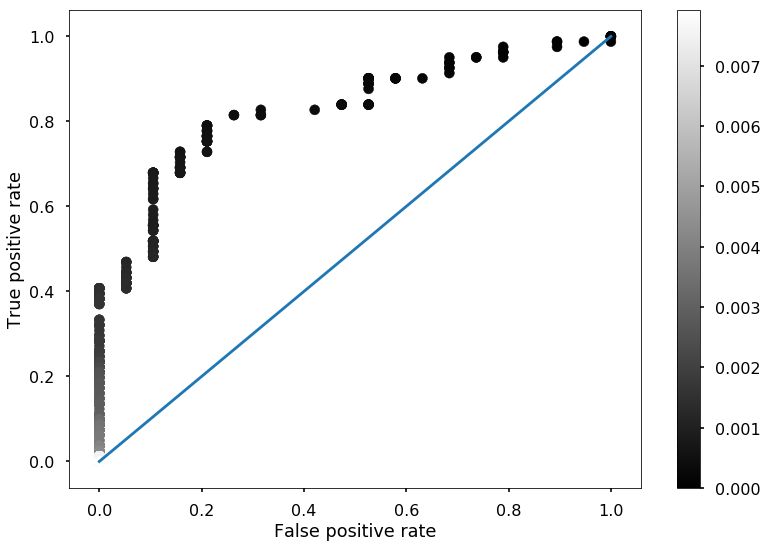

CPU times: user 18.8 s, sys: 54.8 ms, total: 18.8 s
Wall time: 18.8 s


In [22]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 48
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [31]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
WINDOWS = [48, 24, 4, 2]
# WINDOWS = [48]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']


In [33]:
len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(APPROACHES)


216

In [71]:
(10*216)/60

36.0

In [66]:
APPROACH

'prediction_sin_insight_trend'

In [99]:
CHANGE_POINT

396

In [ ]:
actual[np.isnan(actual) == False] = 1
actual[np.isnan(actual) == True] = 0

In [114]:
predicted[np.isnan(predicted) == False] = 1
predicted[np.isnan(predicted) == True] = 0

In [103]:
len(actual)

100000

In [77]:
len(predicted)

100000

In [84]:
thresholds

array([0.        , 0.00970113, 0.01940226, ..., 9.67202862, 9.68172975,
       9.69143088])

In [121]:
confusion_matrix(actual[thresholds == 0],
                  predicted[thresholds == 0],labels=[0,1]) 

array([[ 0, 20],
       [ 0, 80]])

In [122]:
%%time
test = [confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

CPU times: user 823 ms, sys: 7.83 ms, total: 830 ms
Wall time: 846 ms


In [127]:
rec, spec = [], []
for i in test:
    r,s = get_metrics(i)
    rec.append(r)
    spec.append(s)


1000

In [117]:
confusion_matrix(
actual[thresholds == 0.0],
predicted[thresholds == 0.0])

array([[ 0, 20],
       [ 0, 80]])

In [87]:
[i for i in set(thresholds)]

[0.0,
 0.41714867655730536,
 0.9507109372701379,
 1.3096528217496797,
 1.6685947062292215,
 1.9014218745402758,
 2.0275365907087632,
 2.13424904285133,
 2.2603637590198176,
 2.386478475188305,
 2.493190927330872,
 2.6193056434993593,
 3.2110746962899555,
 4.006567521352724,
 5.005784118687664,
 6.0050007160226055,
 3.8028437490805516,
 8.003433910692488,
 9.002650508027427,
 4.0550731814175265,
 4.394612801871148,
 4.646842234208123,
 4.986381854661744,
 5.238611286998719,
 5.57815090745234,
 5.830380339789315,
 6.422149392579911,
 6.674378824916886,
 7.013918445370507,
 7.266147877707482,
 7.605687498161103,
 7.857916930498078,
 8.110146362835053,
 8.1974565509517,
 2.7454203596678473,
 8.449685983288674,
 8.53699617140532,
 8.701915415625649,
 8.789225603742295,
 3.5894188447954183,
 9.04145503607927,
 9.293684468416245,
 9.380994656532891,
 9.54591390075322,
 9.633224088869866,
 0.5044588646739507,
 2.531995455382714,
 3.12376450817331,
 3.715533560963906,
 4.307302613754502,
 4.559

In [143]:
APPROACH

'prediction_sin_insight_trend'

In [12]:

# from itertools import product

In [25]:
def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

In [33]:
def prediction_sin_insight_trend_2(i):
    time_series = generated[0]
    window = 48
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

In [174]:
t_clf = linear_model.LinearRegression()
t_clf.fit()

In [181]:
def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression(n_jobs=4)
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

In [ ]:
def test_fun()

In [26]:
%%time
for i in range(100):
    t_generated = data_generator()
    t_cp_1 = prediction_sin_insight_trend(t_generated[0], 48)

CPU times: user 12.8 s, sys: 75.5 ms, total: 12.9 s
Wall time: 13 s


In [ ]:
p.map()

In [207]:
p.close()

In [23]:
%%time
with Pool() as p:
    t_cp_1 = p.map(prediction_sin_insight_trend,range(100))


CPU times: user 13.8 ms, sys: 19.1 ms, total: 32.9 ms
Wall time: 5.56 s


In [64]:
def cp_detection_modeling(approach = 'approximation_mean', 
                          iterations = 1000, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    gen_list = np.empty((iterations,400))
    for i in range(iterations):
        gen_list[i,:] = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)[0]
    with Pool() as p:
#         cp_1 = p.map(prediction_sin_insight_trend_2,range(iterations))
        cp_1 = p.starmap(prediction_sin_insight_trend,zip(gen_list, repeat(_window)))
#             cp_1 = prediction_sin_insight_trend(generated[0], _window)
#             cp_1 = prediction_sin_insight_trend(generated[0], _window)
#         else:
#             raise ValueError("Unrecognized approach")
        
#         for threshold in threshold_list:
#             act[counter] = generated[1]
#             print(cp_1)
#             pred[counter] = cp_detection(cp_1, threshold, change_point)
#             tr[counter] = threshold
#             counter += 1
        
    return([act, pred, tr])

In [17]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 48
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )


recall = []
specificity = []

actual[np.isnan(actual) == False] = 1
actual[np.isnan(actual) == True] = 0
predicted[np.isnan(predicted) == False] = 1
predicted[np.isnan(predicted) == True] = 0

test = [confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

for i in test:
    r,s = get_metrics(i)
    recall.append(r)
    specificity.append(s)


    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

CPU times: user 3.5 s, sys: 37.7 ms, total: 3.54 s
Wall time: 3.64 s


ROC AUC: 0.45439999999999997


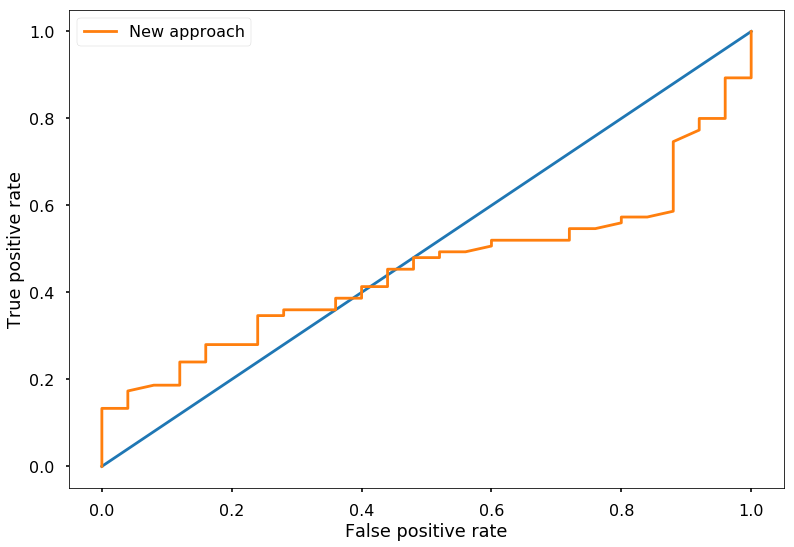

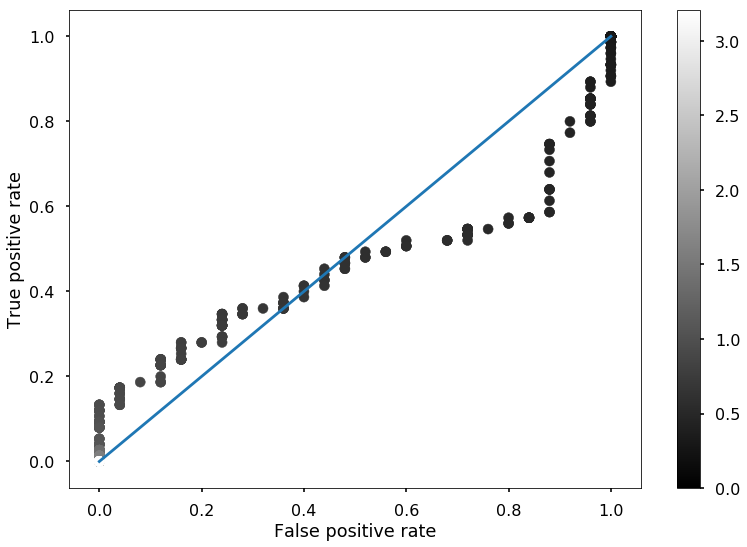

CPU times: user 4.38 s, sys: 93.9 ms, total: 4.47 s
Wall time: 4.56 s


In [21]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling_old(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

recall = []
specificity = []

actual[np.isnan(actual) == False] = 1
actual[np.isnan(actual) == True] = 0
predicted[np.isnan(predicted) == False] = 1
predicted[np.isnan(predicted) == True] = 0

test = [confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

for i in test:
    r,s = get_metrics(i)
    recall.append(r)
    specificity.append(s)

unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

ROC AUC: 0.5516451664277751


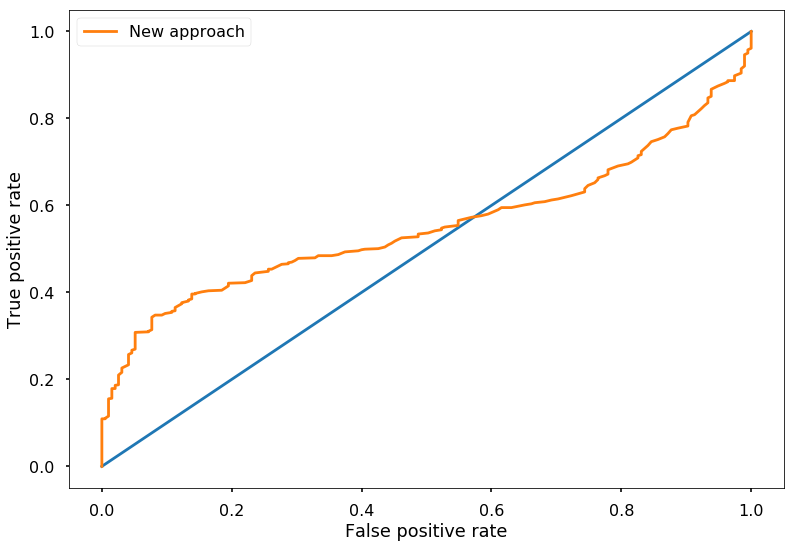

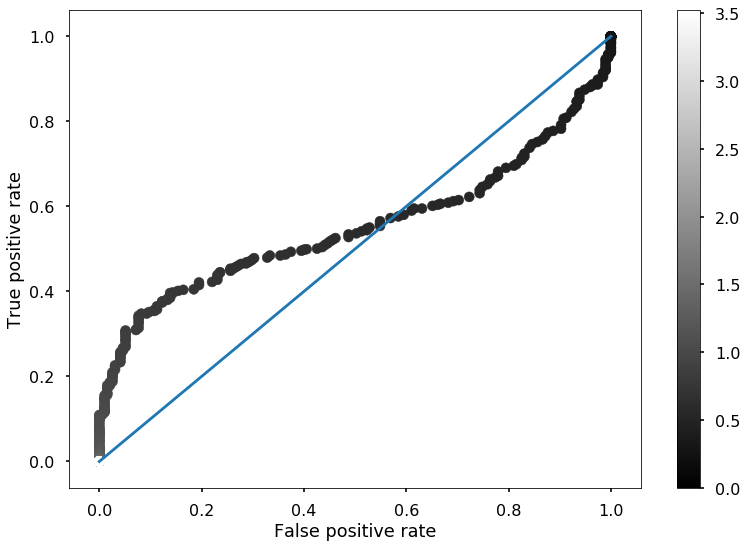

CPU times: user 54.6 s, sys: 778 ms, total: 55.3 s
Wall time: 57.5 s


In [24]:
%%time

ITERATIONS = 1000
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling_old(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [81]:
[confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

ValueError: At least one label specified must be in y_true

In [79]:
actual

array([1., 1., 1., ..., 1., 1., 1.])

In [82]:
predicted[thresholds == 0]

array([], dtype=float64)

In [75]:
sum(predicted)

100000.0

In [77]:
threshold_list

[0.0,
 7.143199413594128e-06,
 1.4286398827188257e-05,
 2.1429598240782387e-05,
 2.8572797654376513e-05,
 3.571599706797064e-05,
 4.2859196481564773e-05,
 5.00023958951589e-05,
 5.714559530875303e-05,
 6.428879472234715e-05,
 7.143199413594128e-05,
 7.85751935495354e-05,
 8.571839296312955e-05,
 9.286159237672367e-05,
 0.0001000047917903178,
 0.00010714799120391193,
 0.00011429119061750605,
 0.00012143439003110018,
 0.0001285775894446943,
 0.00013572078885828843,
 0.00014286398827188256,
 0.0001500071876854767,
 0.0001571503870990708,
 0.00016429358651266494,
 0.0001714367859262591,
 0.00017857998533985322,
 0.00018572318475344735,
 0.00019286638416704147,
 0.0002000095835806356,
 0.00020715278299422973,
 0.00021429598240782385,
 0.00022143918182141798,
 0.0002285823812350121,
 0.00023572558064860623,
 0.00024286878006220036,
 0.0002500119794757945,
 0.0002571551788893886,
 0.00026429837830298274,
 0.00027144157771657687,
 0.000278584777130171,
 0.0002857279765437651,
 0.00029287117595

In [60]:
np.empty((2,5)).shape

(2, 5)

In [ ]:
L = pool.starmap(func, [(1, 1), (2, 1), (3, 1)])

In [ ]:
zip(a_args, repeat(_window))

In [36]:
generated = data_generator(cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = False, 
                           change_type = 'mean',
                           change_point=396)

In [ ]:
p = Pool()
    result = p.map(main, range(1000000))

In [ ]:
search

In [78]:
len(thresholds)

100000

In [69]:
%%time
ITERATIONS = 100

df_temp = pd.DataFrame()

# threshold_list = get_threshold_list(iterations = ITERATIONS,
#                                                     approach = 'prediction_sin_insight_trend',
#                                                     window = 48, 
#                                                     cp_prob = 0.8, 
#                                                     is_multiplicative = False, 
#                                                     is_trend = False, 
#                                                     change_type = 'mean',                         
#                                                     change_point = 396
#                                                    )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = 'prediction_sin_insight_trend',
                                              _window = 48,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              threshold_list = threshold_list,
                                              _is_trend = False, 
                                              _change_type = 'mean',
                                              mode = 'change_end',
                                              change_point = 396
                                                       )


# df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

# precision = []
# recall = []
# specificity = []
# average_delay = []
# # # test = []

actual[np.isnan(actual) == False] = 1
actual[np.isnan(actual) == True] = 0
predicted[np.isnan(predicted) == False] = 1
predicted[np.isnan(predicted) == True] = 0

test = [confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

for i in test:
    r,s = get_metrics(i)
    rec.append(r)
    spec.append(s)



# for tr in threshold_list:
#     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                           )
#     if sum(cp_result[0][:,1]) == 0:
#         precision.append(1)
#     else:
#         precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

#     if sum(cp_result[0][1,:]) == 0:
#         recall.append(1)
#     else:
#         recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

#     if sum(cp_result[0][0,:]) == 0:
#         specificity.append(1)
#     else:
#         specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

#     if cp_result[1]:
#         average_delay.append(np.mean(cp_result[1]))

# unspecificity = [1-x for x in specificity]

# unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

# df_temp = df_temp.append(pd.DataFrame(
#     {
#         'approach': APPROACH, 
#         'change_type': CHANGE_TYPE,
#         'is_trend': IS_TREND,
#         'window': WINDOW, 
#         'cp_prob': CP_PROB, 
#         'is_multiplicative': IS_MULTIPLICATIVE, 
#         'change_point': CHANGE_POINT,
#         'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
#     }, index=[0]), ignore_index=True
# )



CPU times: user 51.5 ms, sys: 21.8 ms, total: 73.3 ms
Wall time: 5.61 s


In [140]:
(2.32*216)/60

8.351999999999999

In [139]:
(11.2*216)/60

40.32

In [135]:
(18.3*216)/60

65.88000000000001

In [48]:
(5*216)/60

4.166666666666667

In [51]:
len(threshold_list)

1000

In [52]:
10.9*1000

10900.0

In [61]:
df_cp.loc[df_cp['threshold'] == tr, 'actual']

999   NaN
Name: actual, dtype: float64

In [62]:
df_cp.loc[df_cp['threshold'] == tr, 'predicted']

999   NaN
Name: predicted, dtype: float64

In [63]:
df_cp

,actual,predicted,threshold
0,NaN,396.0,0.000000
1,NaN,397.0,0.002503
2,NaN,397.0,0.005007
3,NaN,397.0,0.007510
4,NaN,397.0,0.010014
5,NaN,397.0,0.012517
6,NaN,397.0,0.015020
7,NaN,397.0,0.017524
8,NaN,397.0,0.020027
9,NaN,397.0,0.022531


In [60]:
%%time

cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                       df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                      )

CPU times: user 12.8 ms, sys: 1.39 ms, total: 14.2 ms
Wall time: 13 ms


In [ ]:
def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 

In [553]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 24, 4, 2]
WINDOWS = [48]
IS_TRENDS = [False, True]
# IS_TRENDS = [False]
CHANGE_TYPES = ['mean', 'trend', 'local']
# CHANGE_TYPES = ['trend']
# CHANGE_TYPES = ['mean']
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']

# APPROACHES = ['approximation_mean']
# APPROACHES = ['prediction_mean']

In [554]:
(len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(APPROACHES)*3)/60

2.7

In [555]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
CHANGE_POINT = 396

df_results = pd.DataFrame()

for WINDOW in WINDOWS:
    print('Start at {}'.format(datetime.datetime.now()))
    for APPROACH in APPROACHES:
        print('Approach {}'.format(APPROACH))
        print('Loop at {}'.format(datetime.datetime.now()))
        for IS_TREND in IS_TRENDS:
            for CHANGE_TYPE in CHANGE_TYPES:
                threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                    approach = APPROACH,
                                                    window = WINDOW, 
                                                    cp_prob = CP_PROB, 
                                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                                    is_trend = IS_TREND, 
                                                    change_type = CHANGE_TYPE,                         
                                                    change_point = CHANGE_POINT
                                                   )

                actual, predicted, thresholds = [], [], []
                actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                                              approach = APPROACH,
                                                              _window = WINDOW,
                                                              _cp_prob = CP_PROB,
                                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                                              threshold_list = threshold_list,
                                                              _is_trend = IS_TREND, 
                                                              _change_type = CHANGE_TYPE,
                                                              mode = 'change_end',
                                                              change_point = CHANGE_POINT
                                                                       )

#                 df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                precision = []
                recall = []
                specificity = []
                average_delay = []
                # test = []
                for tr in threshold_list:
                    cp_result = confusion_matrix(
                                    (np.isnan(actual[thresholds == tr]) == False)*1,
                                    (np.isnan(predicted[thresholds == tr]) == False)*1
                                )
#                     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                                           )
                    if sum(cp_result[:,1]) == 0:
                        precision.append(1)
                    else:
                        precision.append(cp_result[1,1]/sum(cp_result[:,1]))

                    if sum(cp_result[1,:]) == 0:
                        recall.append(1)
                    else:
                        recall.append(cp_result[1,1]/sum(cp_result[1,:]))

                    if sum(cp_result[0,:]) == 0:
                        specificity.append(1)
                    else:
                        specificity.append(cp_result[0,0]/sum(cp_result[0,:]))    

#                     if cp_result[1]:
#                         average_delay.append(np.mean(cp_result[1]))

                unspecificity = [1-x for x in specificity]

                unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

                df_results = df_results.append(pd.DataFrame(
                    {
                        'approach': APPROACH, 
                        'change_type': CHANGE_TYPE,
                        'is_trend': IS_TREND,
                        'window': WINDOW, 
                        'cp_prob': CP_PROB, 
                        'is_multiplicative': IS_MULTIPLICATIVE, 
                        'change_point': CHANGE_POINT,
                        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                    }, index=[0]), ignore_index=True
                )


Start at 2019-04-21 13:36:46.641476
Approach approximation_mean
Loop at 2019-04-21 13:36:46.641613
Approach prediction_mean
Loop at 2019-04-21 13:37:09.662593
Approach naive
Loop at 2019-04-21 13:37:33.814860
Approach approximation_trend
Loop at 2019-04-21 13:38:17.575126
Approach approximation_sin_trend
Loop at 2019-04-21 13:43:48.056715
Approach approximation_sin_insight_trend
Loop at 2019-04-21 13:50:11.275623
Approach prediction_trend
Loop at 2019-04-21 13:56:27.414714
Approach prediction_sin_trend
Loop at 2019-04-21 13:58:54.881137
Approach prediction_sin_insight_trend
Loop at 2019-04-21 14:01:22.907883
CPU times: user 20min 34s, sys: 7.89 s, total: 20min 42s
Wall time: 27min 13s


In [556]:
df_results.head(10)

,ROC AUC,approach,change_point,change_type,cp_prob,is_multiplicative,is_trend,window
0,0.907732,approximation_mean,396,mean,0.8,False,False,48
1,0.339770,approximation_mean,396,trend,0.8,False,False,48
2,0.739679,approximation_mean,396,local,0.8,False,False,48
3,0.603074,approximation_mean,396,mean,0.8,False,True,48
4,0.667411,approximation_mean,396,trend,0.8,False,True,48
5,0.670746,approximation_mean,396,local,0.8,False,True,48
6,0.450942,prediction_mean,396,mean,0.8,False,False,48
7,0.379743,prediction_mean,396,trend,0.8,False,False,48
8,0.927002,prediction_mean,396,local,0.8,False,False,48
9,0.522001,prediction_mean,396,mean,0.8,False,True,48


In [557]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'window',
                          'change_point'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [398]:
import scipy.stats as st

In [416]:
def sd_auc(AUC, N_pos, N_neg):
    AUC_s = AUC**2
    Q_1 = AUC/(2-AUC)
    Q_2 = (2*AUC_s)/(1+AUC)
    AUC_SD = AUC*(1-AUC) + (N_pos-1)*(Q_1-AUC_s) + (N_neg-1)*(Q_2-AUC_s)
    AUC_SD = AUC_SD/(N_pos*N_neg)
    AUC_SD = AUC_SD**(1/2)
    return(AUC_SD)

def auc_conf_interval(AUC, N_pos, N_neg, confidence_level):
    z_score = st.norm.ppf(1-(1-confidence_level)/2)
    sd = sd_auc(AUC, N_pos, N_neg)*z_score
    return([AUC-sd, AUC+sd])

In [558]:
auc_conf_interval(0.296, 20, 80, 0.95)

[0.18000488228995254, 0.41199511771004743]

In [564]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 24, 4, 2]
WINDOWS = [48]
# IS_TRENDS = [False, True]
IS_TRENDS = [True]
# CHANGE_TYPES = ['mean', 'trend', 'local']
CHANGE_TYPES = ['trend']
# CHANGE_TYPES = ['local']
# APPROACHES = ['approximation_sin_insight_trend']

APPROACHES = ['approximation_mean']
# APPROACHES = ['prediction_mean']

In [565]:
%%time

ITERATIONS = 500
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
CHANGE_POINT = 396

df_results = pd.DataFrame()

for WINDOW in WINDOWS:
    print('Start at {}'.format(datetime.datetime.now()))
    for APPROACH in APPROACHES:
        print('Approach {}'.format(APPROACH))
        print('Loop at {}'.format(datetime.datetime.now()))
        for IS_TREND in IS_TRENDS:
            for CHANGE_TYPE in CHANGE_TYPES:
                threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                    approach = APPROACH,
                                                    window = WINDOW, 
                                                    cp_prob = CP_PROB, 
                                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                                    is_trend = IS_TREND, 
                                                    change_type = CHANGE_TYPE,                         
                                                    change_point = CHANGE_POINT
                                                   )

                actual, predicted, thresholds = [], [], []
                actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                                              approach = APPROACH,
                                                              _window = WINDOW,
                                                              _cp_prob = CP_PROB,
                                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                                              threshold_list = threshold_list,
                                                              _is_trend = IS_TREND, 
                                                              _change_type = CHANGE_TYPE,
                                                              mode = 'change_end',
                                                              change_point = CHANGE_POINT
                                                                       )

#                 df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                precision = []
                recall = []
                specificity = []
                average_delay = []
                # test = []
                for tr in threshold_list:
                    cp_result = confusion_matrix(
                                    (np.isnan(actual[thresholds == tr]) == False)*1,
                                    (np.isnan(predicted[thresholds == tr]) == False)*1
                                )
#                     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                                           )
                    if sum(cp_result[:,1]) == 0:
                        precision.append(1)
                    else:
                        precision.append(cp_result[1,1]/sum(cp_result[:,1]))

                    if sum(cp_result[1,:]) == 0:
                        recall.append(1)
                    else:
                        recall.append(cp_result[1,1]/sum(cp_result[1,:]))

                    if sum(cp_result[0,:]) == 0:
                        specificity.append(1)
                    else:
                        specificity.append(cp_result[0,0]/sum(cp_result[0,:]))    

#                     if cp_result[1]:
#                         average_delay.append(np.mean(cp_result[1]))

                unspecificity = [1-x for x in specificity]

                unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

                df_results = df_results.append(pd.DataFrame(
                    {
                        'approach': APPROACH, 
                        'change_type': CHANGE_TYPE,
                        'is_trend': IS_TREND,
                        'window': WINDOW, 
                        'cp_prob': CP_PROB, 
                        'is_multiplicative': IS_MULTIPLICATIVE, 
                        'change_point': CHANGE_POINT,
                        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                    }, index=[0]), ignore_index=True
                )



Start at 2019-04-21 17:52:18.308939
Approach approximation_mean
Loop at 2019-04-21 17:52:18.309146
CPU times: user 15.1 s, sys: 101 ms, total: 15.2 s
Wall time: 15.5 s


In [563]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'window',
                          'change_point'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

,,,,,ROC AUC
,,,,approach,approximation_sin_insight_trend
is_multiplicative,is_trend,change_type,window,change_point,
False,True,trend,48,396,0.471742


ROC AUC: 0.45482778091473736


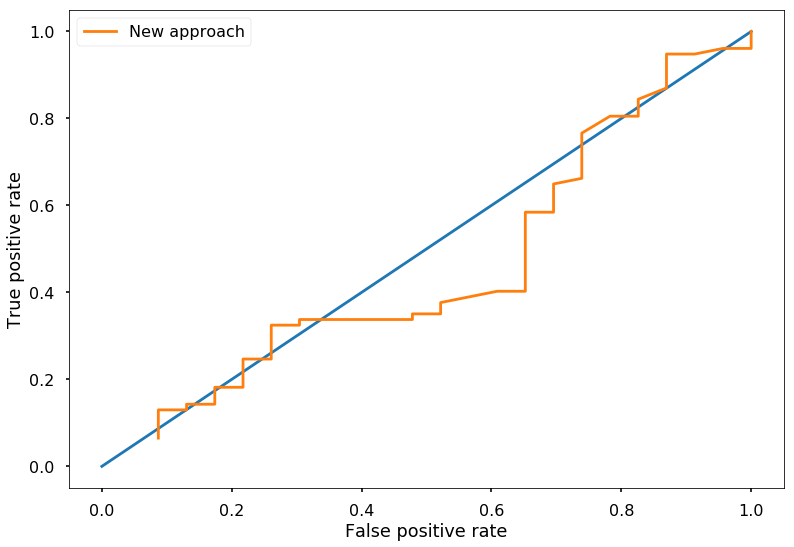

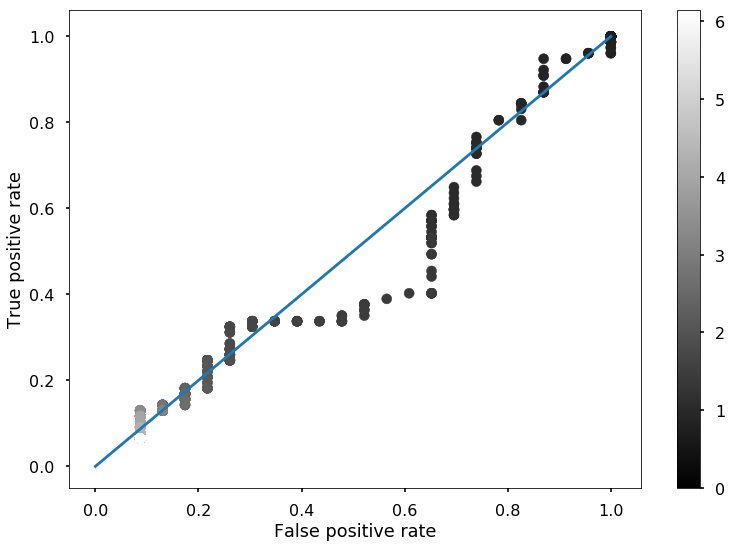

CPU times: user 8.29 s, sys: 80.7 ms, total: 8.37 s
Wall time: 7.95 s


In [551]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 24
IS_TREND = True
CHANGE_TYPE = 'local'
APPROACH = 'naive'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling_old(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

recall = []
specificity = []

actual[np.isnan(actual) == False] = 1
actual[np.isnan(actual) == True] = 0
predicted[np.isnan(predicted) == False] = 1
predicted[np.isnan(predicted) == True] = 0

test = [confusion_matrix(actual[thresholds == i],
                  predicted[thresholds == i],labels=[0,1])
        for i in threshold_list]

for i in test:
    r,s = get_metrics(i)
    recall.append(r)
    specificity.append(s)

unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [549]:
threshold_list

[0.0,
 0.004129000050105511,
 0.008258000100211021,
 0.012387000150316532,
 0.016516000200422043,
 0.020645000250527554,
 0.024774000300633064,
 0.028903000350738575,
 0.033032000400844086,
 0.0371610004509496,
 0.04129000050105511,
 0.04541900055116062,
 0.04954800060126613,
 0.05367700065137164,
 0.05780600070147715,
 0.06193500075158266,
 0.06606400080168817,
 0.07019300085179368,
 0.0743220009018992,
 0.0784510009520047,
 0.08258000100211021,
 0.08670900105221573,
 0.09083800110232124,
 0.09496700115242675,
 0.09909600120253226,
 0.10322500125263777,
 0.10735400130274328,
 0.11148300135284879,
 0.1156120014029543,
 0.11974100145305981,
 0.12387000150316532,
 0.12799900155327082,
 0.13212800160337634,
 0.13625700165348187,
 0.14038600170358737,
 0.14451500175369286,
 0.1486440018037984,
 0.1527730018539039,
 0.1569020019040094,
 0.1610310019541149,
 0.16516000200422043,
 0.16928900205432595,
 0.17341800210443145,
 0.17754700215453695,
 0.18167600220464247,
 0.185805002254748,
 0.189

In [ ]:
cp_detection_modeling_old(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )